In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from source.utils import *
from source.preprocess import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [3]:
path = "../../Desktop/DLC_social_1/"
path2 = "../../Desktop/DLC_social_2/"

# Set up and design the project

In [4]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [5]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [6]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.61 s, sys: 739 ms, total: 3.35 s
Wall time: 1.13 s


In [7]:
%%time
DLC_social_2 = project(path=path2,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5')

CPU times: user 6.27 s, sys: 940 ms, total: 7.21 s
Wall time: 1.58 s


# Run project

In [8]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 10.4 s, sys: 528 ms, total: 10.9 s
Wall time: 14 s


source.preprocess.coordinates

In [9]:
%%time
DLC_social_2_coords = DLC_social_2.run(verbose=True)
print(DLC_social_2_coords)
type(DLC_social_2_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
DLC analysis of 31 videos
CPU times: user 5.73 s, sys: 316 ms, total: 6.05 s
Wall time: 7.8 s


source.preprocess.coordinates

# Generate coords

In [10]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

ptest2 = DLC_social_2_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest2._type

CPU times: user 1.54 s, sys: 88.1 ms, total: 1.63 s
Wall time: 1.51 s


'coords'

In [11]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

dtest2 = DLC_social_2_coords.get_distances(speed=0, length='00:10:00')
dtest2._type

CPU times: user 959 ms, sys: 615 ms, total: 1.57 s
Wall time: 1.58 s


'dists'

In [12]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

atest2 = DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest2._type

CPU times: user 233 ms, sys: 125 ms, total: 358 ms
Wall time: 358 ms


'angles'

# Visualization playground

In [13]:
#ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [14]:
#Plot animation of trajectory over time with different smoothings
#plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
#         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Mouse Center Trajectory using different exponential smoothings')
#plt.legend()
#plt.show()

# Dimensionality reduction playground

In [15]:
#pca = ptest.pca(4, 1000)

In [16]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [17]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [18]:
mtest2 = merge_tables(DLC_social_2_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [19]:
#pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [20]:
pttest = mtest.preprocess(window_size=11, window_step=6, filter=None, standard_scaler=True)
pttest.shape

(117507, 11, 28)

In [21]:
pttest2 = mtest2.preprocess(window_size=11, window_step=6, filter=None, standard_scaler=True)
pttest2.shape

(77504, 11, 28)

In [22]:
#plt.plot(pttest[2,:,2], label='normal')
#plt.plot(pptest[2,:,2], label='gaussian')
#plt.legend()
#plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [23]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [24]:
NAME = 'Baseline_MMVAEP_512_wu10_10comp'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

Using TensorFlow backend.


In [26]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [27]:
ae.summary()

Model: "SEQ_2_SEQ_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SEQ_2_SEQ_Encoder (Sequentia (None, 32)                1400736   
_________________________________________________________________
SEQ_2_SEQ_Decoder (Sequentia multiple                  2395580   
Total params: 3,781,820
Trainable params: 3,778,236
Non-trainable params: 3,584
_________________________________________________________________


In [28]:
encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(pttest.shape,
                                                                               loss='ELBO+MMD',
                                                                               number_of_components=10,
                                                                               kl_warmup_epochs=10,
                                                                               mmd_warmup_epochs=10,
                                                                               predictor=False).build()
gmvaep.build(pttest.shape)

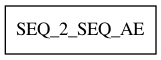

In [29]:
tf.keras.utils.plot_model(ae, show_shapes=True)

In [30]:
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-3 * 10**(epoch / 20))

In [31]:
# tf.config.experimental_run_functions_eagerly(False)
# history = ae.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
#                    validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
#                    callbacks=[tensorboard_callback])

In [ ]:
#GMVAEP witout prediction
#tf.config.experimental_run_functions_eagerly(False)
history = gmvaep.fit(x=pttest[:-1], y=pttest[:-1], epochs=100, batch_size=512, verbose=1,
                  validation_data=(pttest2[:-1], pttest2[:-1]),
                  callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

Epoch 1/100
  1/230 [..............................] - ETA: 0s - loss: 153592.6250 - mae: 1.3298 - kl_divergence: 0.0000e+00 - kl_rate: 0.0000e+00 - mmd: 0.0000e+00 - mmd_rate: 0.0000e+00

In [ ]:
# GMVAEP with prediction
# tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
#                      validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
#                      callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

## Encoding interpretation playground

In [ ]:
# encodings = encoder.predict(pttest)
# clusters  = np.argmax(grouper.predict(pttest), axis=1)

In [ ]:
# from collections import Counter
# Counter(clusters)

In [ ]:
# %matplotlib notebook
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D 

# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# encs = encodings[:]
# ax.scatter(encs[:,0],encs[:,1],encs[:,2], c=clusters[:])

# ax.set_xlabel('Encoding 0')
# ax.set_ylabel('Encoding 1')
# ax.set_zlabel('Encoding 2')

# plt.show()